<a href="https://colab.research.google.com/github/iamkarthikbk/ee5333-2025/blob/main/mywork/tut2-31jan/Partition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mip

## Partitioning

* Kernighan Lin Algorithm for bi-partitioning ($V'$) :
  + $G=(V,E)$
  + $A$, $B$ $\subset V$
  + $A \cup B = V$
  + $A\cap B = ∅$
  + $|A| = |B| = \dfrac{|V|}{2}$
  + Flowchart:

    <img src="https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/part/fig/KL_flowchart.jpg" width=698 height=612 />


In [2]:
# Vertex class to hold the partition index, neighbours, EA, EB and D values
class Vertex:
  def __init__(self, i, part):
    self._id = i
    self._nbrs = []
    self._part = part
    self._ea = 0
    self._eb = 0
    self._d  = 0
  def reset(self, part):
    (self._part, self._ea, self._eb, self._d) = (part, 0, 0, 0)
  def __str__(self):
    return '(' + str(self._id) + ',' + str(self._part) + ',' + str(self._ea) + ',' + str(self._eb) + ',' + str(self._d) + ',' + str([i._id for i in self._nbrs]) + ')'
  def __repr__(self):
    return str(self)

# clear the partition, EA, EB and D values
# do this at the beginning of every iteration
def reset(V, A, B):
  for j in range(2):
    partition = A if (0 == j) else B
    for i in partition:
      V[i].reset(j)
  for v in V:
    assert(v._part == 0 or v._part == 1)
    for n in v._nbrs:
      if n._part == 0:
        v._ea += 1
      else:
        v._eb += 1
  for v in V:
    v._d = (v._ea - v._eb) if (v._part == 1) else (v._eb - v._ea)

# Choose the pair whose swap has the maximum gain in number of cuts
def findMaxGain(V, Ap, Bp, E):
  (amax, bmax, gmax) = (-1, -1, -2 * len(E) - 1)
  for a in Ap:
    for b in Bp:
      g = V[a]._d + V[b]._d - (2 if (min(a,b), max(a,b)) in E else 0)
      if gmax < g:
        (amax, bmax, gmax) = (a, b, g)
  assert(amax >= 0 and bmax >= 0)
  return (amax, bmax, gmax)

# update the E and D for only the affected neighbours of a and b
def updateED(V, a, b):
  V[a]._part = 1
  V[b]._part = 0
  for i in [a,b]:
    for n in V[i]._nbrs:
      if i == a:
        n._ea -= 1
        n._eb += 1
      else:
        n._ea += 1
        n._eb -= 1
      n._d = (n._ea - n._eb) if (n._part == 1) else (n._eb - n._ea)

# N is the number of vertices; vertices are {0, 1,... N-1}
# E is the list of edges
# E : list of edges; edge = unordered pair of vertices
# Return value : two sets A, B and the count of number of cuts
def KLPart(N, E):
  if N%2: N+= 1 # make N even if its odd by adding a single no-neighbour vertex
  V = [Vertex(i, -1) for i in range(N)]
  for e in E:
    if e[0] > e[1]: e = (e[1], e[0])
    else: e = (e[0], e[1])
  E = set(E)
  for e in E:
    V[e[0]]._nbrs.append(V[e[1]])
    V[e[1]]._nbrs.append(V[e[0]])
  import random
  Vc = V[:]
  partLen = N//2
  random.shuffle(Vc) # randomly initialize A and B

  A = {Vc[i]._id for i in range(partLen)}
  B = {Vc[i]._id for i in range(partLen, N)}

  print(A)
  print(B)
  maxGain = 1
  while maxGain >= 0:
    Ap, Bp= A.copy(), B.copy()
    reset(V, A, B)
    G, S = [], []
    for p in range(partLen):
      (a, b, g) = findMaxGain(V, Ap, Bp, E)
      updateED(V, a, b)
      Ap.remove(a)
      Bp.remove(b)
      G.append(g)
      S.append((a, b))
    for i in range(1, len(G)):
      G[i] += G[i-1]
    maxGain = max(G)
    maxIndex = G.index(maxGain)
    if maxGain > 0:
      for (a, b) in S[0:maxIndex + 1]:
        A.remove(a)
        B.remove(b)
        A.add(b)
        B.add(a)
    else:
      break

  cut = 0
  for a in A:
    for b in B:
      if (min(a, b), max(a,b)) in E:
        cut += 1
  return (A, B, cut)

In [3]:
print(KLPart(8, [(0,1), (0,4), (0,5), (1,4), (1,5), (4,5), (2,3), (2,6), (2,7), (3,6), (3,7), (6,7), (2,5)]))

{0, 3, 4, 7}
{1, 2, 5, 6}
({2, 3, 6, 7}, {0, 1, 4, 5}, 1)


## Bipartitioning using ILP
+ $x_v$ is the indicator variable for $v$ being in $A$
+ $x_{u,v}$ is the indicator variable for $(u,v)\in E$ being cut
+ <ul>
$\begin{align}
        x_{u,v} = x_u \oplus x_v
\end{align}$
</ul>

+ Objective: $\min\limits_{x_v, x_{u,v}} \sum\limits_{(u,v)\in E}x_{u,v}$
+ Subject to constraints:
<ul>
$\begin{align}
\sum_{v\in V} x_v&=\frac{|V|}{2}\\
x_u - x_v &\leq x_{u,v}, &\forall (u,v) \in E\\
x_v - x_u &\leq x_{u,v}, &\forall (u,v) \in E\\
x_u + x_v &\geq x_{u,v}, &\forall (u,v) \in E\\
x_u + x_v + x_{u,v} &\leq 2, &\forall (u,v) \in E\\
x_v &\in \{0, 1\}, &\forall v \in V\\
x_{u,v} &\in \{0, 1\}, &\forall (u,v) \in E
\end{align}$
</ul>


In [4]:
def bipartition(N, E):
  import mip
  model = mip.Model("Bi-partition")
  x = [model.add_var(f"x_{u}", var_type = mip.BINARY) for u in range(N)]
  x_uv = [model.add_var(f"x_{u}_{v}", var_type = mip.BINARY) for u,v in E]
  model.verbose = 0
  model.objective = mip.minimize(mip.xsum(x_uv))
  model += (mip.xsum(x) == N//2)
  for e, (u,v) in enumerate(E):
  # xor constraints
    model += (x[u] - x[v] <= x_uv[e])
    model += (x[v] - x[u] <= x_uv[e])
    model += (x[u] + x[v] >= x_uv[e])
    model += (x[u] + x[v] + x_uv[e] <= 2)

  model.write("bipartition.lp")
  model.optimize()
  if model.status == mip.OptimizationStatus.OPTIMAL:
    A = [i for i in range(N) if x[i].x >= 0.9]
    B = [i for i in range(N) if x[i].x < 0.9]
    return (A, B, model.objective.x)
  return None



In [5]:
print(bipartition(8, [(0,1), (0,4), (0,5), (1,4), (1,5), (4,5), (2,3), (2,6), (2,7), (3,6), (3,7), (6,7), (2,5)]))

([2, 3, 6, 7], [0, 1, 4, 5], 1.0)


In [6]:
def random_graph(N, fns):
  import networkx as nx
  import time
  g = nx.erdos_renyi_graph(N, 0.4)
  G = []
  for fn in fns:
    t = time.time()
    (A,B,c) = fn(N, g.edges)
    print("runtime : ", time.time() - t, 'cut size : ', c)
    import graphviz
    gv = graphviz.Graph()
    A = list(A)
    B = list(B)
    for i in range(len(A)):
      gv.node(str(A[i]), color='red', shape='circle')
    for i in range(len(B)):
      gv.node(str(B[i]), color='blue', shape='circle')
    for e in g.edges:
      gv.edge(str(e[0]), str(e[1]), splines='line')
    #gv.engine = 'patchwork'
    G.append(gv)
  return G

{1, 3, 4, 7, 9}
{0, 2, 5, 6, 8}
runtime :  0.0003101825714111328 cut size :  6
runtime :  0.28560447692871094 cut size :  6.0


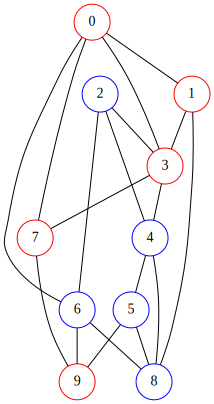

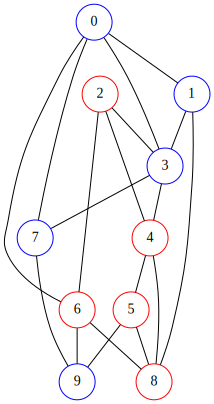

In [7]:
G = random_graph(10, [KLPart, bipartition])
from IPython.display import display
display(G[0], G[1])

In [14]:
!cat bipartition.lp

\Problem name: Bi-partition

Minimize
OBJROW: x_0_3 + x_0_4 + x_0_5 + x_0_8 + x_0_9 + x_1_3 + x_1_5 + x_1_6 + x_1_7 + x_2_3
 + x_2_7 + x_3_5 + x_3_6 + x_3_7 + x_4_7 + x_5_6 + x_5_7 + x_5_8 + x_7_8
Subject To
constr(0):  x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9
 = 5
constr(1):  x_0 - x_3 - x_0_3 <= -0
constr(2):  - x_0 + x_3 - x_0_3 <= -0
constr(3):  x_0 + x_3 - x_0_3 >= -0
constr(4):  x_0 + x_3 + x_0_3 <= 2
constr(5):  x_0 - x_4 - x_0_4 <= -0
constr(6):  - x_0 + x_4 - x_0_4 <= -0
constr(7):  x_0 + x_4 - x_0_4 >= -0
constr(8):  x_0 + x_4 + x_0_4 <= 2
constr(9):  x_0 - x_5 - x_0_5 <= -0
constr(10):  - x_0 + x_5 - x_0_5 <= -0
constr(11):  x_0 + x_5 - x_0_5 >= -0
constr(12):  x_0 + x_5 + x_0_5 <= 2
constr(13):  x_0 - x_8 - x_0_8 <= -0
constr(14):  - x_0 + x_8 - x_0_8 <= -0
constr(15):  x_0 + x_8 - x_0_8 >= -0
constr(16):  x_0 + x_8 + x_0_8 <= 2
constr(17):  x_0 - x_9 - x_0_9 <= -0
constr(18):  - x_0 + x_9 - x_0_9 <= -0
constr(19):  x_0 + x_9 - x_0_9 >= -0
constr(20):  x_0 

## Bipartitioning using ILP - II
+ $x_{v,A}$ is the indicator variable for $v$ being in $A$
+ Similarly define $x_{v,B}$
+ $x_{u,v,A}$ is the indicator variable for $(u,v)\in E$ being contained in $A$

+ Objective: $\max\limits_{x_{u,v,i}} \sum\limits_{(u,v)\in E}x_{u,v,A} + x_{u,v,B}$
+ Subject to constraints:
<ul>
$\begin{align}
\sum_{v\in V} x_{v,i}&=\frac{|V|}{2}, &\forall v \in V\\
x_{v,A}, x_{v,B} &\in \{0, 1\}, &\forall v \in V\\
x_{u,v,A} &\leq x_{u,A}, &\forall (u,v) \in E\\
x_{u,v,A} &\leq x_{v,A}, &\forall (u,v) \in E\\
x_{v,A} + x_{v,B} &=1 , &\forall v \in V\\
x_{u,v,A}, x_{u,v,B} &\in \{0, 1\}, &\forall (u,v) \in E
\end{align}$
</ul>

In [10]:
def bipartition2(N, E):
  import mip
  model = mip.Model("Bi-partition2")
  model.verbose = 0

  # [karthik] define a list of binary indicator variables that define
  ## whether a particular vertex is in the partition A
  xa = [model.add_var(f"xa_{u}", var_type = mip.BINARY) for u in range(N)]

  # [karthik] similarly another list of binary indicator variables that define
  ## whether a particular vertex is in the partition B
  xb = [model.add_var(f"xb_{u}", var_type = mip.BINARY) for u in range(N)]

  # [karthik] now a third list of binary indicator variables that define whether a vertex
  ## pair is fully contained in A.
  xa_uv = [model.add_var(f"xa_{u}_{v}", var_type = mip.BINARY) for u,v in E]

  # [karthik] similarly another list of binary varuables to indicate whether a vertex is
  ## fully contained in B.
  xb_uv = [model.add_var(f"xb_{u}_{v}", var_type = mip.BINARY) for u,v in E]

  # [karthik] now we define the objective for the ILP solver as "to maximise the number
  ## of edges being contained". this is an "overkill" for a 2-way partition
  ## but scales well for a k-way partitioning problem. this will introduce a lot
  ## more variables and constraints than actually required _for a 2 way problem_
  model.objective = mip.minimize(mip.xsum((xa_uv[i] + xb_uv[i]) for i in range(len(E)))) # is this len(E) correct ?

  # [karthik] now we add in constraints for the model to solve the formed ILP.
  ## 1. number of vertices grouped in all partitions should be equal ??????
  model += (mip.xsum(xa) == N//2)
  model += (mip.xsum(xb) == N//2)

  ## 2. these constraints may look like they have a typo but they do not. we are
  ## trying to say that if a vertex is in a certain partition, then the edge
  ## is either contained or it is cut. seems unnecessarry to me at the beginning
  ## but then when we are trying to _maximise_ the objective, we basically push
  ## the solver to have as many contained edges as possible.
  for e, (u,v) in enumerate(E):
    model += (xa_uv[e] <= xa[u])
    model += (xa_uv[e] <= xa[v])
    model += (xb_uv[e] <= xb[u])
    model += (xb_uv[e] <= xb[v])

  ## 3. a node can not be in both partitions
    model += (xa[u] + xb[u] == 1)
    model += (xa[v] + xb[v] == 1)

  model.write("bipartition2.lp")
  model.optimize()
  if model.status == mip.OptimizationStatus.OPTIMAL:
    A = [i for i in range(N) if xa[i].x >= 0.9]
    B = [i for i in range(N) if xb[i].x < 0.9]
    return (A, B, model.objective.x)
  return None


{1, 2, 4, 5, 6, 8, 9, 11, 12, 18}
{0, 3, 7, 10, 13, 14, 15, 16, 17, 19}
runtime :  0.002670764923095703 cut size :  21
runtime :  4.686444044113159 cut size :  21.0
runtime :  0.010760068893432617 cut size :  0.0


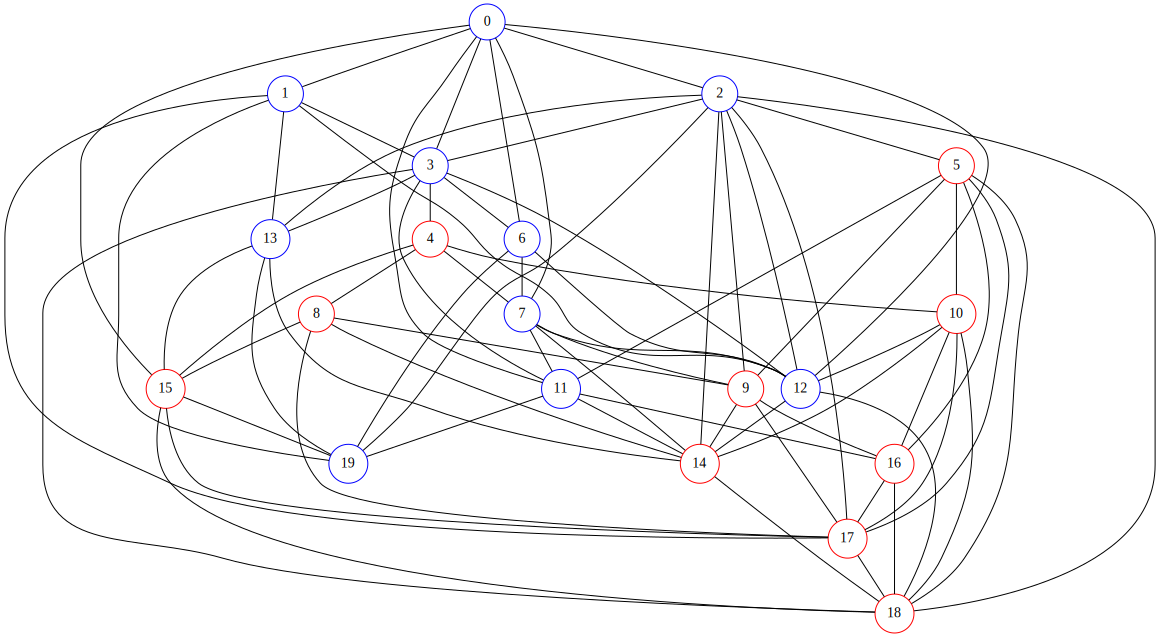

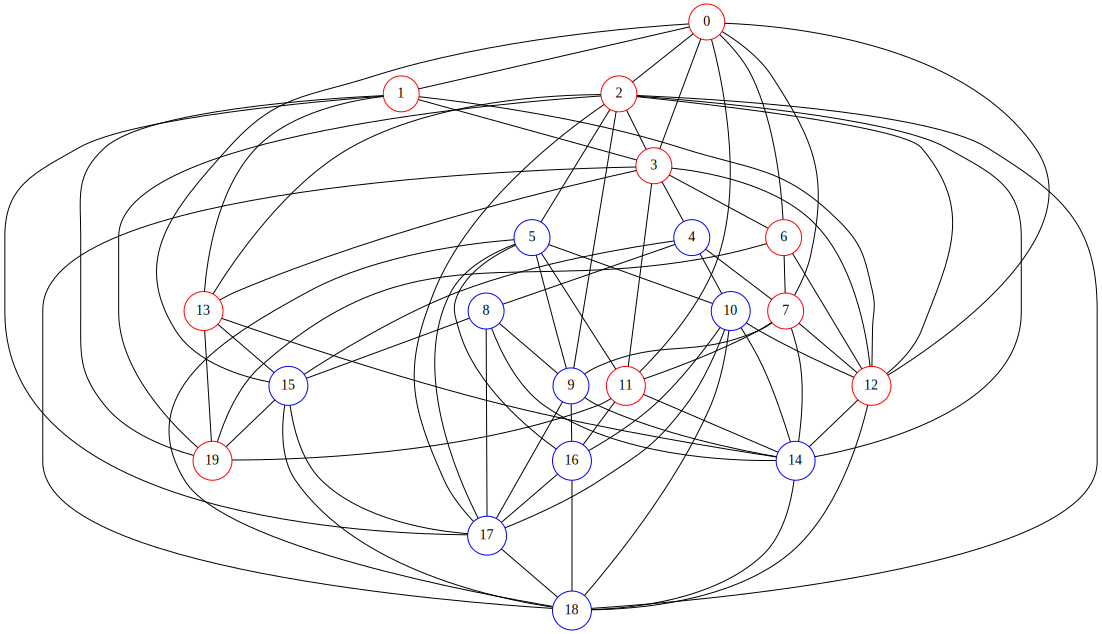

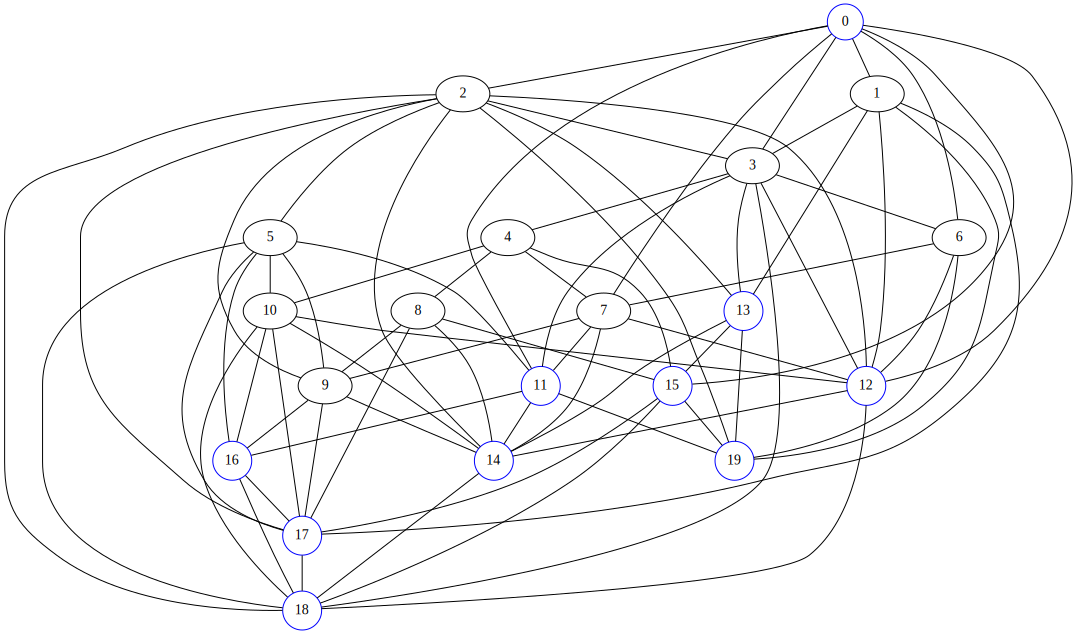

In [11]:
G = random_graph(20, [KLPart, bipartition, bipartition2])
from IPython.display import display
display(G[0], G[1], G[2])

## LEF DEF Parsing

- Install the LEFDEFParser from the the wheel file : [LEFDEFParser-0.1-cp310-cp310-linux_x86_64.whl](https://github.com/srini229/EE5333_tutorials/blob/master/parser/LEFDEFParser-0.1-cp310-cp310-linux_x86_64.whl)
- Download example LEF and DEF files: [Nangate.lef](https://github.com/srini229/EE5333_tutorials/blob/master/parser/Nangate.lef) and [example.def](https://github.com/srini229/EE5333_tutorials/blob/master/parser/example.def)

    <img src="https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/part/fig/example_cir.png" width=340 height=195 />



In [ ]:
!pip install --break-system-packages https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/parser/LEFDEFParser-0.1-cp311-cp311-linux_x86_64.whl
!rm *.{lef,def}
!wget https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/parser/{Nangate.lef,example.def}
!wget https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/parser/sample.{lef,def}

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.0/562.0 kB 6.3 MB/s eta 0:00:00
--2024-01-25 10:43:01--  https://raw.githubusercontent.com/srini229/EE5333_tutorials/master/parser/example.def
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 899 [text/plain]
Saving to: ‘example.def.2’

example.def.2       100%[===================>]     899  --.-KB/s    in 0s      

2024-01-25 10:43:01 (27.8 MB/s) - ‘example.def.2’ saved [899/899]

VERSION 5.8 ;
DIVIDERCHAR "/" ;
BUSBITCHARS "[]" ;
DESIGN example ;
UNITS DISTANCE MICRONS 2000 ;

DIEAREA ( 83600 71820 ) ( 104400 91200 ) ;

COMPONENTS 6 ;
- a NAND2_X1 ;
- b NAND2_X1 ;
- c NAND2_X1 ;
- d NAND2_X1 ;
- e NAND2_X1 ;
- f INV_X1 ;
END COMPONENTS

PINS 0 ;
- n1 + NET n1 + DIRECTION INPUT ;
- n2 + NET n2 + DIRECTION INP

In [ ]:
V,E = loadNetlist('Nangate.lef', 'example.def')
Atotal = sum(V[u]._area for u in V)
maxCellArea = max(V[u]._area for u in V)
print(Atotal, round(maxCellArea,2))

In [ ]:
V,E = loadNetlist('sample.lef', 'sample.def')
Atotal = sum(V[u]._area for u in V)
maxCellArea = max(V[u]._area for u in V)
print(Atotal, round(maxCellArea,2))